In [118]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [119]:
def get_distance_squared_pairs(particles, pair_indices):
    delta_x = torch.diff(torch.stack([particles[0][pair_indices[:,0]], particles[0][pair_indices[:,1]]]).T).squeeze()
    delta_y = torch.diff(torch.stack([particles[1][pair_indices[:,0]], particles[1][pair_indices[:,1]]]).T).squeeze()
    
    return delta_x**2 + delta_y**2

In [120]:
def compute_new_velocity(velocity1, velocity2, position1, position2):
    velocity1_new = velocity1 - torch.sum((velocity1-velocity2)*(position1-position2), axis=0)/torch.sum((position1-position2)**2, axis=0) * (position1 - position2)
    velocity2_new = velocity2 - torch.sum((velocity1-velocity2)*(position1-position2), axis=0)/torch.sum((position2-position1)**2, axis=0) * (position2 - position1)
    
    return velocity1_new, velocity2_new

In [121]:
def motion(particles, velocities, pair_ids, iterations, delta_time, radii):
    particles_save = torch.zeros((iterations, particles.shape[0], particles.shape[1]), device=device)
    velocities_save = torch.zeros((iterations, velocities.shape[0], velocities.shape[1]), device=device)
    
    particles_save[0] = particles
    velocities_save[0] = velocities
    
    for i in range(1,iterations):
        intersecting_pairs = pair_ids[get_distance_squared_pairs(particles, pair_ids) < (2*radii)**2]
        velocities[:, intersecting_pairs[:,0]], velocities[:, intersecting_pairs[:,1]] = compute_new_velocity(velocities[:, intersecting_pairs[:,0]], velocities[:, intersecting_pairs[:,1]], particles[:, intersecting_pairs[:,0]], particles[:, intersecting_pairs[:,1]])
        velocities[0,particles[0]>1] = -torch.abs(velocities[0,particles[0]>1])
        velocities[0,particles[0]<0] = torch.abs(velocities[0,particles[0]<0])
        velocities[1,particles[1]>1] = -torch.abs(velocities[1,particles[1]>1])
        velocities[1,particles[1]<0] = torch.abs(velocities[1,particles[1]<0])
        
        particles = particles + velocities * delta_time
        
        particles_save[i] = particles
        velocities_save[i] = velocities
        
    return particles_save, velocities_save

In [127]:
N_PARTICLES = 5000
RADIUS = 0.0005


particles = torch.rand((2, N_PARTICLES), device=device)


right_indices = particles[0] > 0.5
left_indices = particles[0] <= 0.5


velocities = torch.zeros((2, N_PARTICLES), device=device)
velocities[0][right_indices] = -500
velocities[0][left_indices] = 500


ids = torch.arange(N_PARTICLES, device=device)
id_pairs = torch.combinations(ids)


In [129]:
particles_save, velocities_save = motion(particles, velocities, id_pairs, 1000, 0.000008, RADIUS)

In [132]:
v = np.linspace(0, 2000, 1000)
a = 2/500**2
fv = a*v*np.exp(-a*v**2 / 2)

Text(0, 0.5, '# Particles')

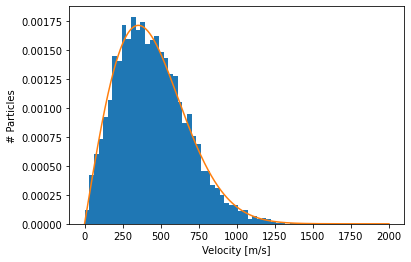

In [135]:
bins = np.linspace(0,1500,50)
plt.figure()

plt.hist(torch.sqrt(torch.sum(velocities_save[-1]**2, axis=0)).cpu(), bins=bins, density=True)
plt.plot(v,fv)
plt.xlabel('Velocity [m/s]')
plt.ylabel('# Particles')